In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ĐỌC DỮ LIỆU GỐC
df = pd.read_csv("Alonhadat.com.vn.csv", dtype=str)
print(f"Kích thước dữ liệu gốc: {df.shape}")
print(f"Các cột: {df.columns.tolist()}")

# Hiển thị dữ liệu gốc để kiểm tra
print("\n--- 10 dòng đầu tiên ---")
print(df[["Giá", "Area", "Property Type", "Location"]].head(10))

Kích thước dữ liệu gốc: (3000, 12)
Các cột: ['URL', 'Property Type', 'Legal Status', 'Title', 'brief', 'Location', 'Giá', 'road-width', 'floors', 'bedroom', 'Thumbnail src', 'Area']

--- 10 dòng đầu tiên ---
              Giá                 Area      Property Type  \
0     Giá: 2,2 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
1       Giá: 2 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
2   Giá: 2,888 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
3    Giá: 2,95 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
4    Giá: 2,89 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
5    Giá: 2,91 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
6    Giá: 2,94 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
7  Giá: 900 triệu  Diện tích: 250 m\n2  Đất thổ cư, đất ở   
8     Giá: 2,6 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   
9    Giá: 2,96 tỷ  Diện tích: 150 m\n2  Đất thổ cư, đất ở   

                                            Location  
0  Đường NH16, Phường Thới Hòa, Thành phố Bến Cát...  
1  Đường V

In [3]:
# LÀM SẠCH DỮ LIỆU CƠ BẢN

# Hàm làm sạch giá
def clean_price(price_str):
    if pd.isna(price_str):
        return None
    price_str = str(price_str).lower().replace(",", ".").strip()
    
    # Loại bỏ giá thỏa thuận
    if "giá thỏa thuận" in price_str or "thương lượng" in price_str or "liên hệ" in price_str:
        return None
    
    # Giá theo đơn vị
    if "tỷ" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000000000  # 1 tỷ = 1 tỷ VND
    elif "triệu" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000000  # 1 triệu = 1,000,000 VND
    elif "ngàn" in price_str or "nghìn" in price_str:
        nums = re.findall(r"[\d\.]+", price_str)
        if nums:
            return float(nums[0]) * 1000  # 1 ngàn = 1,000 VND
    
    # Fallback: tìm số trực tiếp
    nums = re.findall(r"[\d\.]+", price_str)
    if nums:
        num = float(nums[0])
        # Nếu số quá nhỏ (< 100) có thể là tỷ, nếu lớn (> 1000) có thể là triệu
        if num < 100:
            return num * 1000000000  # tỷ
        else:
            return num * 1000000  # triệu
    
    return None

# Hàm làm sạch diện tích
def clean_area(area_str):
    if pd.isna(area_str):
        return None
    area_str = str(area_str).lower().replace(",", ".")
    
    # Tìm số (có thể có dấu chấm thập phân)
    nums = re.findall(r"[\d\.]+", area_str)
    if nums:
        area = float(nums[0])
        # Nếu diện tích quá lớn (> 1000) có thể là nhầm đơn vị
        if area > 1000:
            return area / 100  # chia để điều chỉnh
        return area
    return None

# %%
# Áp dụng làm sạch
df["Price_clean"] = df["Giá"].apply(clean_price)
df["Area_clean"] = df["Area"].apply(clean_area)

# Loại bỏ dòng có giá trị null
initial_count = len(df)
df = df.dropna(subset=["Price_clean", "Area_clean"])
after_clean_count = len(df)

print(f"Đã loại bỏ {initial_count - after_clean_count} dòng có giá/diện tích không hợp lệ")
print(f"Số dòng còn lại: {after_clean_count}")

Đã loại bỏ 1 dòng có giá/diện tích không hợp lệ
Số dòng còn lại: 2999


In [4]:
#  Tính giá/m2
df["Price_per_m2"] = df["Price_clean"] / df["Area_clean"]

# Kiểm tra kết quả làm sạch
sample_data = df[["Giá", "Price_clean", "Area", "Area_clean", "Price_per_m2"]].head(10).copy()
sample_data["Price_clean_formatted"] = sample_data["Price_clean"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "NaN")
sample_data["Price_per_m2_formatted"] = sample_data["Price_per_m2"].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else "NaN")
print(sample_data[["Giá", "Price_clean_formatted", "Area", "Area_clean", "Price_per_m2_formatted"]])

              Giá Price_clean_formatted                 Area  Area_clean  \
0     Giá: 2,2 tỷ         2,200,000,000  Diện tích: 150 m\n2       150.0   
1       Giá: 2 tỷ         2,000,000,000  Diện tích: 150 m\n2       150.0   
2   Giá: 2,888 tỷ         2,888,000,000  Diện tích: 150 m\n2       150.0   
3    Giá: 2,95 tỷ         2,950,000,000  Diện tích: 150 m\n2       150.0   
4    Giá: 2,89 tỷ         2,890,000,000  Diện tích: 150 m\n2       150.0   
5    Giá: 2,91 tỷ         2,910,000,000  Diện tích: 150 m\n2       150.0   
6    Giá: 2,94 tỷ         2,940,000,000  Diện tích: 150 m\n2       150.0   
7  Giá: 900 triệu           900,000,000  Diện tích: 250 m\n2       250.0   
8     Giá: 2,6 tỷ         2,600,000,000  Diện tích: 150 m\n2       150.0   
9    Giá: 2,96 tỷ         2,960,000,000  Diện tích: 150 m\n2       150.0   

  Price_per_m2_formatted  
0             14,666,667  
1             13,333,333  
2             19,253,333  
3             19,666,667  
4             19,266,667  
5

In [5]:
#  XỬ LÝ OUTLIERS

def remove_outliers_multiple(df, columns):
    """
    Xử lý outliers cho nhiều cột cùng lúc
    """
    if len(df) == 0:
        return df
        
    mask = pd.Series([True] * len(df))
    
    for col in columns:
        if col not in df.columns:
            print(f" Cảnh báo: Cột '{col}' không tồn tại")
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Đảm bảo lower không âm cho các giá trị không thể âm
        if col in ['Price_clean', 'Area_clean', 'Price_per_m2']:
            lower = max(lower, 0)
        
        col_mask = (df[col] >= lower) & (df[col] <= upper)
        mask = mask & col_mask
        
        removed_count = len(df) - col_mask.sum()
        print(f"{col}: Giữ lại {col_mask.sum():,} / {len(df):,} dòng (Loại bỏ {removed_count:,} outliers)")
    
    result_df = df[mask].copy()
    print(f"\nTổng số dòng sau xử lý outliers: {len(result_df):,}")
    return result_df

# Áp dụng xử lý outliers
df_clean = remove_outliers_multiple(df, ['Price_clean', 'Area_clean', 'Price_per_m2'])

Price_clean: Giữ lại 2,646 / 2,999 dòng (Loại bỏ 353 outliers)
Area_clean: Giữ lại 2,703 / 2,999 dòng (Loại bỏ 296 outliers)
Price_per_m2: Giữ lại 2,786 / 2,999 dòng (Loại bỏ 213 outliers)

Tổng số dòng sau xử lý outliers: 2,422


In [6]:
#  XỬ LÝ CÁC BIẾN PHÂN LOẠI

# Tách địa chỉ nếu có cột Location
if 'Location' in df_clean.columns:
    location_split = df_clean['Location'].str.split(',', n=2, expand=True)
    if location_split.shape[1] >= 3:
        df_clean['Street'] = location_split[0].str.strip()
        df_clean['District'] = location_split[1].str.strip()
        df_clean['Province'] = location_split[2].str.strip()
        print("Đã tách cột Location thành Street, District, Province")
    else:
        print(" Cột Location không có đủ thông tin để tách")

# Thống kê biến phân loại
categorical_cols = ['Property Type', 'Legal Status']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"\n--- Phân phối {col} ---")
        print(df_clean[col].value_counts().head(10))

Đã tách cột Location thành Street, District, Province

--- Phân phối Property Type ---
Property Type
Nhà mặt tiền                   1570
Đất thổ cư, đất ở               427
Nhà trong hẻm                   313
Biệt thự, nhà liền kề            57
Căn hộ chung cư                  26
Nhà hàng, khách sạn              21
Đất nền, liền kề, đất dự án       7
Phòng trọ, nhà trọ                1
Name: count, dtype: int64

--- Phân phối Legal Status ---
Legal Status
Sổ hồng/ Sổ đỏ    2369
Giấy tờ hợp lệ       2
Name: count, dtype: int64


In [7]:
#  TRÍCH XUẤT TỪ KHÓA TỪ TIÊU ĐỀ

if 'Title' in df_clean.columns:
    # Làm sạch title
    df_clean['Title'] = df_clean['Title'].fillna('')
    df_clean['Title_Length'] = df_clean['Title'].str.len()
    
    # Trích xuất từ khóa quan trọng
    important_keywords = ['chính chủ', 'giá rẻ', 'view đẹp', 'mặt tiền', 'sổ đỏ', 'sổ hồng']
    for keyword in important_keywords:
        df_clean[f'Keyword_{keyword.replace(" ", "_")}'] = df_clean['Title'].str.contains(keyword, case=False, na=False).astype(int)
    
    print("Đã trích xuất các từ khóa quan trọng từ tiêu đề")

Đã trích xuất các từ khóa quan trọng từ tiêu đề


In [8]:
# THỐNG KÊ MÔ TẢ

def format_currency(x):
    """Định dạng tiền tệ dễ đọc"""
    if pd.isna(x):
        return "NaN"
    if x >= 1e9:  # Tỷ đồng
        return f"{x/1e9:,.1f} tỷ"
    elif x >= 1e6:  # Triệu đồng
        return f"{x/1e6:,.0f} triệu"
    elif x >= 1e3:  # Ngàn đồng
        return f"{x/1e3:,.0f} nghìn"
    else:
        return f"{x:,.0f} VND"

def format_area(x):
    """Định dạng diện tích"""
    if pd.isna(x):
        return "NaN"
    return f"{x:,.0f} m²"

# Thống kê cho biến định lượng
numeric_cols = ['Price_clean', 'Area_clean', 'Price_per_m2']
print("Thống kê biến định lượng")

for col in numeric_cols:
    if col in df_clean.columns:
        print(f"\n--- {col} ---")
        stats = df_clean[col].describe()
        
        if col == 'Price_clean':
            formatter = format_currency
        elif col == 'Area_clean':
            formatter = format_area
        else:  # Price_per_m2
            formatter = lambda x: f"{format_currency(x)}/m²" if pd.notna(x) else "NaN"
        
        print(f"Số lượng:    {int(stats['count']):,}")
        print(f"Trung bình:  {formatter(stats['mean'])}")
        print(f"Độ lệch chuẩn: {formatter(stats['std'])}")
        print(f"Tối thiểu:   {formatter(stats['min'])}")
        print(f"25%:         {formatter(stats['25%'])}")
        print(f"Trung vị:    {formatter(stats['50%'])}")
        print(f"75%:         {formatter(stats['75%'])}")
        print(f"Tối đa:      {formatter(stats['max'])}")

# Thống kê cho biến phân loại
print("\nThống kê biến phân loại")

categorical_stats = ['Property Type', 'Legal Status', 'District', 'Province']
for col in categorical_stats:
    if col in df_clean.columns:
        print(f"\n--- Phân phối {col} ---")
        value_counts = df_clean[col].value_counts()
        for i, (value, count) in enumerate(value_counts.head(10).items()):
            percentage = (count / len(df_clean)) * 100
            print(f"{i+1:2d}. {value:<30} {count:>5,} dòng ({percentage:.1f}%)")

Thống kê biến định lượng

--- Price_clean ---
Số lượng:    2,422
Trung bình:  9.2 tỷ
Độ lệch chuẩn: 7.3 tỷ
Tối thiểu:   22 nghìn
25%:         4.0 tỷ
Trung vị:    7.3 tỷ
75%:         12.6 tỷ
Tối đa:      35.0 tỷ

--- Area_clean ---
Số lượng:    2,422
Trung bình:  89 m²
Độ lệch chuẩn: 44 m²
Tối thiểu:   1 m²
25%:         58 m²
Trung vị:    82 m²
75%:         107 m²
Tối đa:      242 m²

--- Price_per_m2 ---
Số lượng:    2,422
Trung bình:  122 triệu/m²
Độ lệch chuẩn: 97 triệu/m²
Tối thiểu:   440 VND/m²
25%:         52 triệu/m²
Trung vị:    96 triệu/m²
75%:         174 triệu/m²
Tối đa:      455 triệu/m²

Thống kê biến phân loại

--- Phân phối Property Type ---
 1. Nhà mặt tiền                   1,570 dòng (64.8%)
 2. Đất thổ cư, đất ở                427 dòng (17.6%)
 3. Nhà trong hẻm                    313 dòng (12.9%)
 4. Biệt thự, nhà liền kề             57 dòng (2.4%)
 5. Căn hộ chung cư                   26 dòng (1.1%)
 6. Nhà hàng, khách sạn               21 dòng (0.9%)
 7. Đất nền, li

In [9]:
#  PHÂN TÍCH MỐI QUAN HỆ CƠ BẢN

# Mối quan hệ giữa diện tích và giá
if all(col in df_clean.columns for col in ['Area_clean', 'Price_clean']):
    correlation = df_clean['Area_clean'].corr(df_clean['Price_clean'])
    print(f" Tương quan giữa Diện tích và Giá: {correlation:.3f}")
    
    if abs(correlation) > 0.5:
        print("   → Mối quan hệ mạnh")
    elif abs(correlation) > 0.3:
        print("   → Mối quan hệ trung bình")
    else:
        print("   → Mối quan hệ yếu")

# Giá trung bình theo loại hình BĐS
if 'Property Type' in df_clean.columns:
    print(f"\n Giá trung bình theo loại hình bất động sản")
    price_by_type = df_clean.groupby('Property Type')['Price_clean'].agg(['count', 'mean', 'median']).round(0)
    price_by_type = price_by_type.sort_values('count', ascending=False)
    
    for prop_type, row in price_by_type.head().iterrows():
        mean_price = format_currency(row['mean'])
        median_price = format_currency(row['median'])
        print(f"   {prop_type:<20}: {row['count']:>3} BĐS | TB: {mean_price:>15} | Trung vị: {median_price:>15}")

 Tương quan giữa Diện tích và Giá: 0.160
   → Mối quan hệ yếu

 Giá trung bình theo loại hình bất động sản
   Nhà mặt tiền        : 1570.0 BĐS | TB:         10.2 tỷ | Trung vị:          8.0 tỷ
   Đất thổ cư, đất ở   : 427.0 BĐS | TB:          5.9 tỷ | Trung vị:          3.6 tỷ
   Nhà trong hẻm       : 313.0 BĐS | TB:          8.2 tỷ | Trung vị:          6.7 tỷ
   Biệt thự, nhà liền kề: 57.0 BĐS | TB:         13.2 tỷ | Trung vị:         11.8 tỷ
   Căn hộ chung cư     : 26.0 BĐS | TB:          5.7 tỷ | Trung vị:          5.3 tỷ


In [10]:
#  XUẤT KẾT QUẢ

# Lưu file đã làm sạch
output_file = "Alonhadat_cleaned.csv"
df_clean.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f" Đã lưu file đã làm sạch: {output_file}")

# Tóm tắt kết quả
print(f"\n Tóm tắt kết quả")
print(f"• Số lượng BĐS ban đầu: {len(df):,}")
print(f"• Số lượng BĐS sau làm sạch: {len(df_clean):,}")
print(f"• Tỷ lệ giữ lại: {len(df_clean)/len(df)*100:.1f}%")

if len(df_clean) > 0:
    avg_price = format_currency(df_clean['Price_clean'].mean())
    avg_area = format_area(df_clean['Area_clean'].mean())
    avg_price_m2 = format_currency(df_clean['Price_per_m2'].mean()) + "/m²"
    
    print(f"• Giá trung bình: {avg_price}")
    print(f"• Diện tích trung bình: {avg_area}")
    print(f"• Giá/m² trung bình: {avg_price_m2}")

print(f"\n Hoàn tất xử lý dữ liệu")

# %%
# Hiển thị một số dòng kết quả cuối cùng
print("\n=== Dữ liệu sau khi xử lý ===")
final_cols = [col for col in ['Price_clean', 'Area_clean', 'Price_per_m2', 'Property Type', 'District', 'Province'] if col in df_clean.columns]
print(df_clean[final_cols].head(10))

 Đã lưu file đã làm sạch: Alonhadat_cleaned.csv

 Tóm tắt kết quả
• Số lượng BĐS ban đầu: 2,999
• Số lượng BĐS sau làm sạch: 2,422
• Tỷ lệ giữ lại: 80.8%
• Giá trung bình: 9.2 tỷ
• Diện tích trung bình: 89 m²
• Giá/m² trung bình: 122 triệu/m²

 Hoàn tất xử lý dữ liệu

=== Dữ liệu sau khi xử lý ===
     Price_clean  Area_clean  Price_per_m2      Property Type  \
0   2.200000e+09       150.0  1.466667e+07  Đất thổ cư, đất ở   
1   2.000000e+09       150.0  1.333333e+07  Đất thổ cư, đất ở   
2   2.888000e+09       150.0  1.925333e+07  Đất thổ cư, đất ở   
3   2.950000e+09       150.0  1.966667e+07  Đất thổ cư, đất ở   
4   2.890000e+09       150.0  1.926667e+07  Đất thổ cư, đất ở   
5   2.910000e+09       150.0  1.940000e+07  Đất thổ cư, đất ở   
6   2.940000e+09       150.0  1.960000e+07  Đất thổ cư, đất ở   
8   2.600000e+09       150.0  1.733333e+07  Đất thổ cư, đất ở   
9   2.960000e+09       150.0  1.973333e+07  Đất thổ cư, đất ở   
10  2.850000e+09       150.0  1.900000e+07  Đất thổ

In [11]:
# Set style cho đồ thị
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [12]:
# Load dữ liệu đã làm sạch
try:
    df = pd.read_csv("Alonhadat_cleaned.csv")
    print(f" Kích thước dữ liệu EDA: {df.shape}")
except:
    print(" Không tìm thấy file Alonhadat_cleaned.csv")
    print(" Hãy chạy lại code xử lý dữ liệu trước khi chạy EDA")
    df = pd.DataFrame()

if len(df) == 0:
    print(" Không có dữ liệu để phân tích")
else:
    print(" Dữ liệu đã được load thành công")

 Kích thước dữ liệu EDA: (2422, 25)
 Dữ liệu đã được load thành công


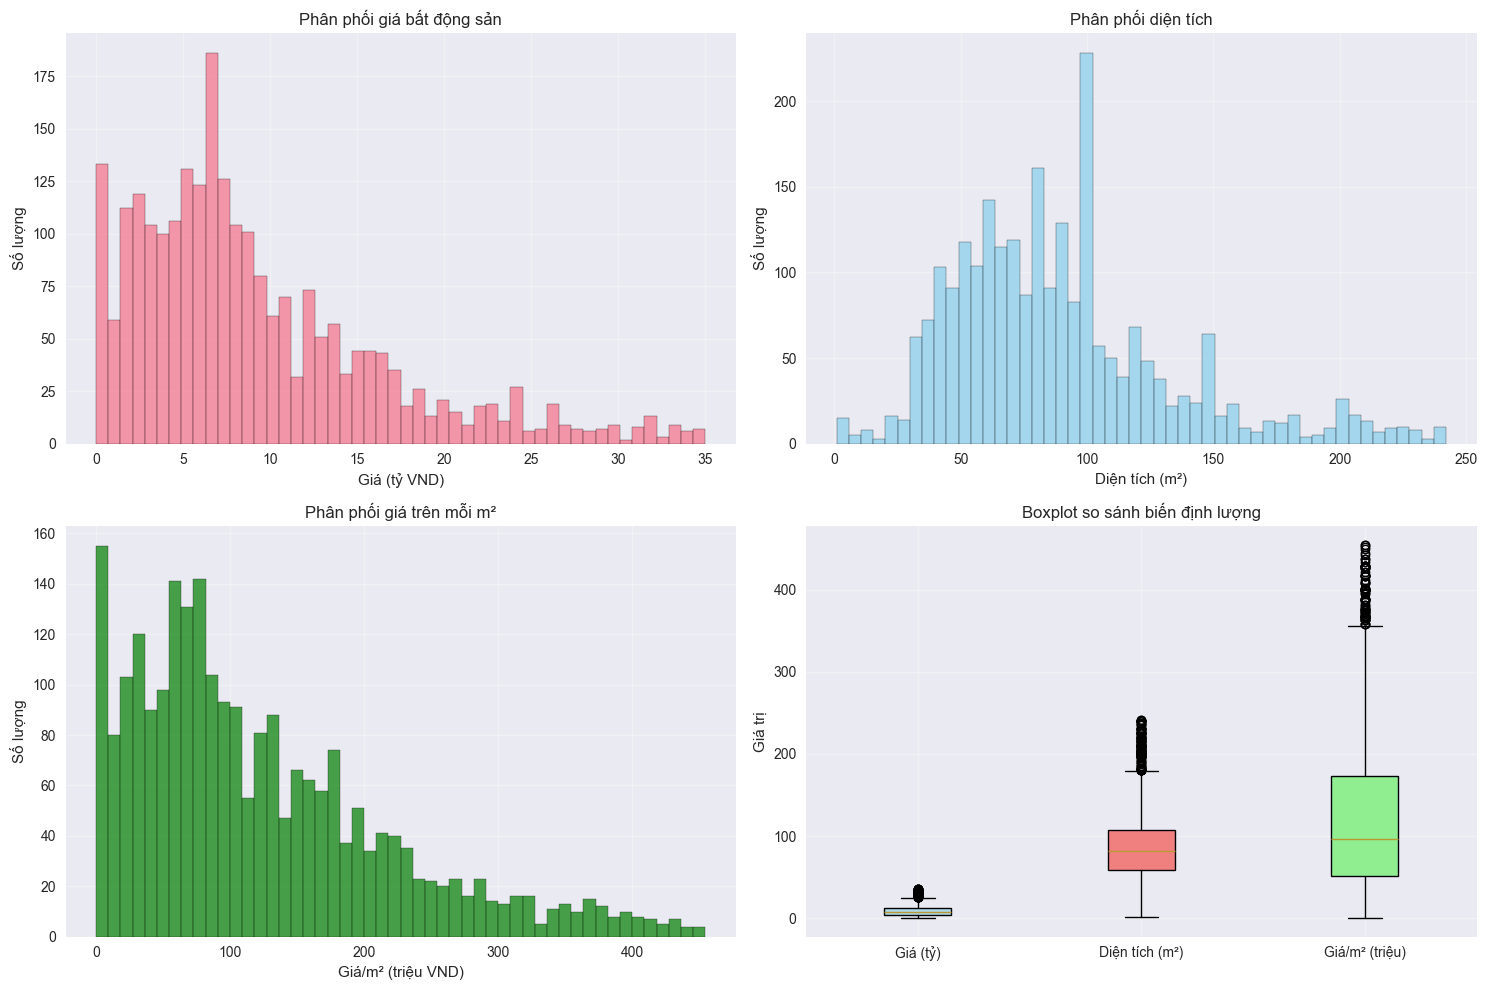

In [13]:
##  PHÂN TÍCH PHÂN PHỐI CÁC BIẾN CHÍNH

# %%
if len(df) > 0:
    # 1.1 Phân phối giá bất động sản
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Phân phối giá (chuyển đổi đơn vị trước khi vẽ)
    price_billion = df['Price_clean'] / 1e9
    axes[0,0].hist(price_billion, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Giá (tỷ VND)')
    axes[0,0].set_ylabel('Số lượng')
    axes[0,0].set_title('Phân phối giá bất động sản')
    axes[0,0].grid(True, alpha=0.3)

    # Phân phối diện tích
    axes[0,1].hist(df['Area_clean'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0,1].set_xlabel('Diện tích (m²)')
    axes[0,1].set_ylabel('Số lượng')
    axes[0,1].set_title('Phân phối diện tích')
    axes[0,1].grid(True, alpha=0.3)

    # Phân phối giá/m² (chuyển đổi đơn vị)
    price_m2_million = df['Price_per_m2'] / 1e6
    axes[1,0].hist(price_m2_million, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1,0].set_xlabel('Giá/m² (triệu VND)')
    axes[1,0].set_ylabel('Số lượng')
    axes[1,0].set_title('Phân phối giá trên mỗi m²')
    axes[1,0].grid(True, alpha=0.3)

    # Boxplot so sánh (dữ liệu đã chuyển đổi)
    plot_data = [price_billion, df['Area_clean'], price_m2_million]
    labels = ['Giá (tỷ)', 'Diện tích (m²)', 'Giá/m² (triệu)']
    box_plot = axes[1,1].boxplot(plot_data, labels=labels, patch_artist=True)
    
    # Tô màu cho boxplot
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[1,1].set_ylabel('Giá trị')
    axes[1,1].set_title('Boxplot so sánh biến định lượng')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
# %%
if len(df) > 0:
    # 1.2 Thống kê mô tả chi tiết
    print(" THỐNG KÊ MÔ TẢ CHI TIẾT")

    def detailed_stats(series, name):
        print(f"\n--- {name} ---")
        print(f"Mean: {series.mean():,.0f}")
        print(f"Median: {series.median():,.0f}")
        print(f"Std: {series.std():,.0f}")
        print(f"Min: {series.min():,.0f}")
        print(f"Max: {series.max():,.0f}")
        print(f"Skewness: {series.skew():.3f} ({'Lệch phải' if series.skew() > 0 else 'Lệch trái' if series.skew() < 0 else 'Đối xứng'})")
        print(f"Kurtosis: {series.kurtosis():.3f}")

    detailed_stats(df['Price_clean'], "Giá bất động sản (VND)")
    detailed_stats(df['Area_clean'], "Diện tích (m²)")
    detailed_stats(df['Price_per_m2'], "Giá trên m² (VND/m²)")

 THỐNG KÊ MÔ TẢ CHI TIẾT

--- Giá bất động sản (VND) ---
Mean: 9,218,037,445
Median: 7,300,000,000
Std: 7,260,757,175
Min: 22,000
Max: 35,000,000,000
Skewness: 1.255 (Lệch phải)
Kurtosis: 1.367

--- Diện tích (m²) ---
Mean: 89
Median: 82
Std: 44
Min: 1
Max: 242
Skewness: 1.056 (Lệch phải)
Kurtosis: 1.159

--- Giá trên m² (VND/m²) ---
Mean: 122,346,588
Median: 96,000,000
Std: 97,349,140
Min: 440
Max: 454,545,455
Skewness: 1.095 (Lệch phải)
Kurtosis: 0.779


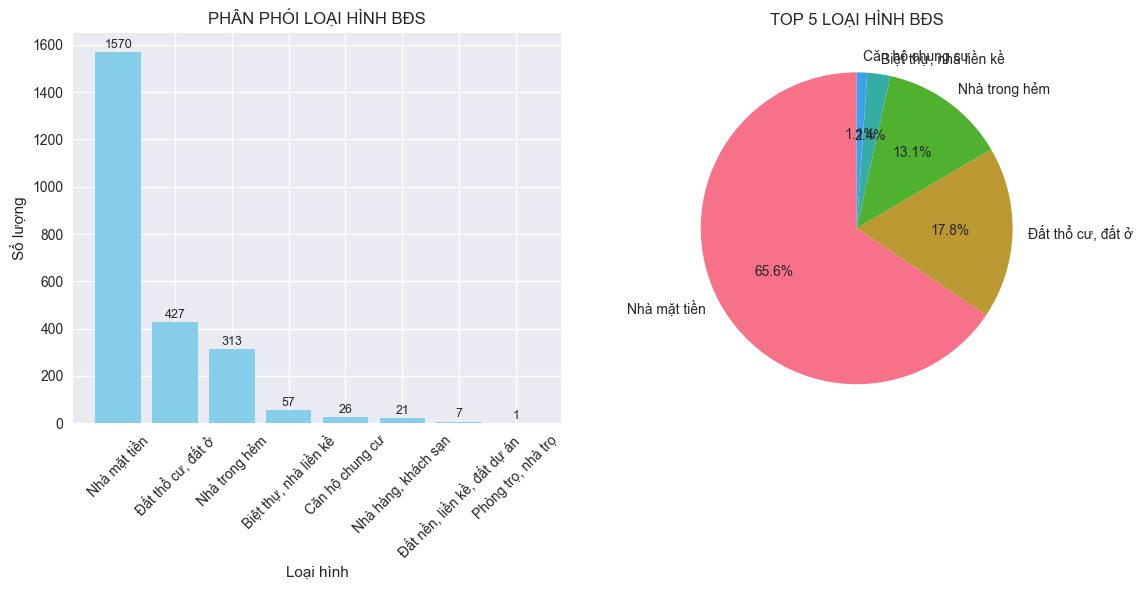

 GIÁ TRUNG BÌNH THEO LOẠI HÌNH BĐS
                             Count    Price_Mean  Price_Median  Area_Mean  \
Property Type                                                               
Nhà mặt tiền                  1570  1.015867e+10  8.000000e+09       85.0   
Đất thổ cư, đất ở              427  5.869512e+09  3.650000e+09      107.0   
Nhà trong hẻm                  313  8.202914e+09  6.700000e+09       75.0   
Biệt thự, nhà liền kề           57  1.322863e+10  1.180000e+10      165.0   
Căn hộ chung cư                 26  5.673077e+09  5.300000e+09       77.0   
Nhà hàng, khách sạn             21  1.757048e+10  1.800000e+10      106.0   
Đất nền, liền kề, đất dự án      7  3.094714e+09  1.800000e+09      100.0   
Phòng trọ, nhà trọ               1  1.100000e+10  1.100000e+10      160.0   

                             Price_m2_Mean  
Property Type                               
Nhà mặt tiền                   139854481.0  
Đất thổ cư, đất ở               62020355.0  
Nhà trong hẻm 

In [15]:
##  PHÂN TÍCH THEO LOẠI HÌNH BẤT ĐỘNG SẢN

# %%
if len(df) > 0 and 'Property Type' in df.columns:
    # 2.1 Phân phối loại hình BĐS
    plt.figure(figsize=(12, 6))
    prop_type_counts = df['Property Type'].value_counts()
    
    # Biểu đồ cột
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(len(prop_type_counts.head(10))), prop_type_counts.head(10).values, color='skyblue')
    plt.title('PHÂN PHỐI LOẠI HÌNH BĐS')
    plt.xlabel('Loại hình')
    plt.ylabel('Số lượng')
    plt.xticks(range(len(prop_type_counts.head(10))), prop_type_counts.head(10).index, rotation=45)
    
    # Thêm số liệu trên đầu cột
    for bar, count in zip(bars, prop_type_counts.head(10).values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{count}', 
                ha='center', va='bottom', fontsize=9)
    
    # Biểu đồ tròn
    plt.subplot(1, 2, 2)
    top_5 = prop_type_counts.head(5)
    plt.pie(top_5.values, labels=top_5.index, autopct='%1.1f%%', startangle=90)
    plt.title('TOP 5 LOẠI HÌNH BĐS')
    
    plt.tight_layout()
    plt.show()

    # 2.2 Giá trung bình theo loại hình
    price_by_type = df.groupby('Property Type').agg({
        'Price_clean': ['count', 'mean', 'median'],
        'Area_clean': 'mean',
        'Price_per_m2': 'mean'
    }).round(0)
    
    price_by_type.columns = ['Count', 'Price_Mean', 'Price_Median', 'Area_Mean', 'Price_m2_Mean']
    price_by_type = price_by_type.sort_values('Count', ascending=False)
    
    print(" GIÁ TRUNG BÌNH THEO LOẠI HÌNH BĐS")
    print(price_by_type.head(10))

In [16]:
# Đổi tên cột 'bedroom' thành 'Bedroom'
df = df.rename(columns={'bedroom': 'Bedroom'})

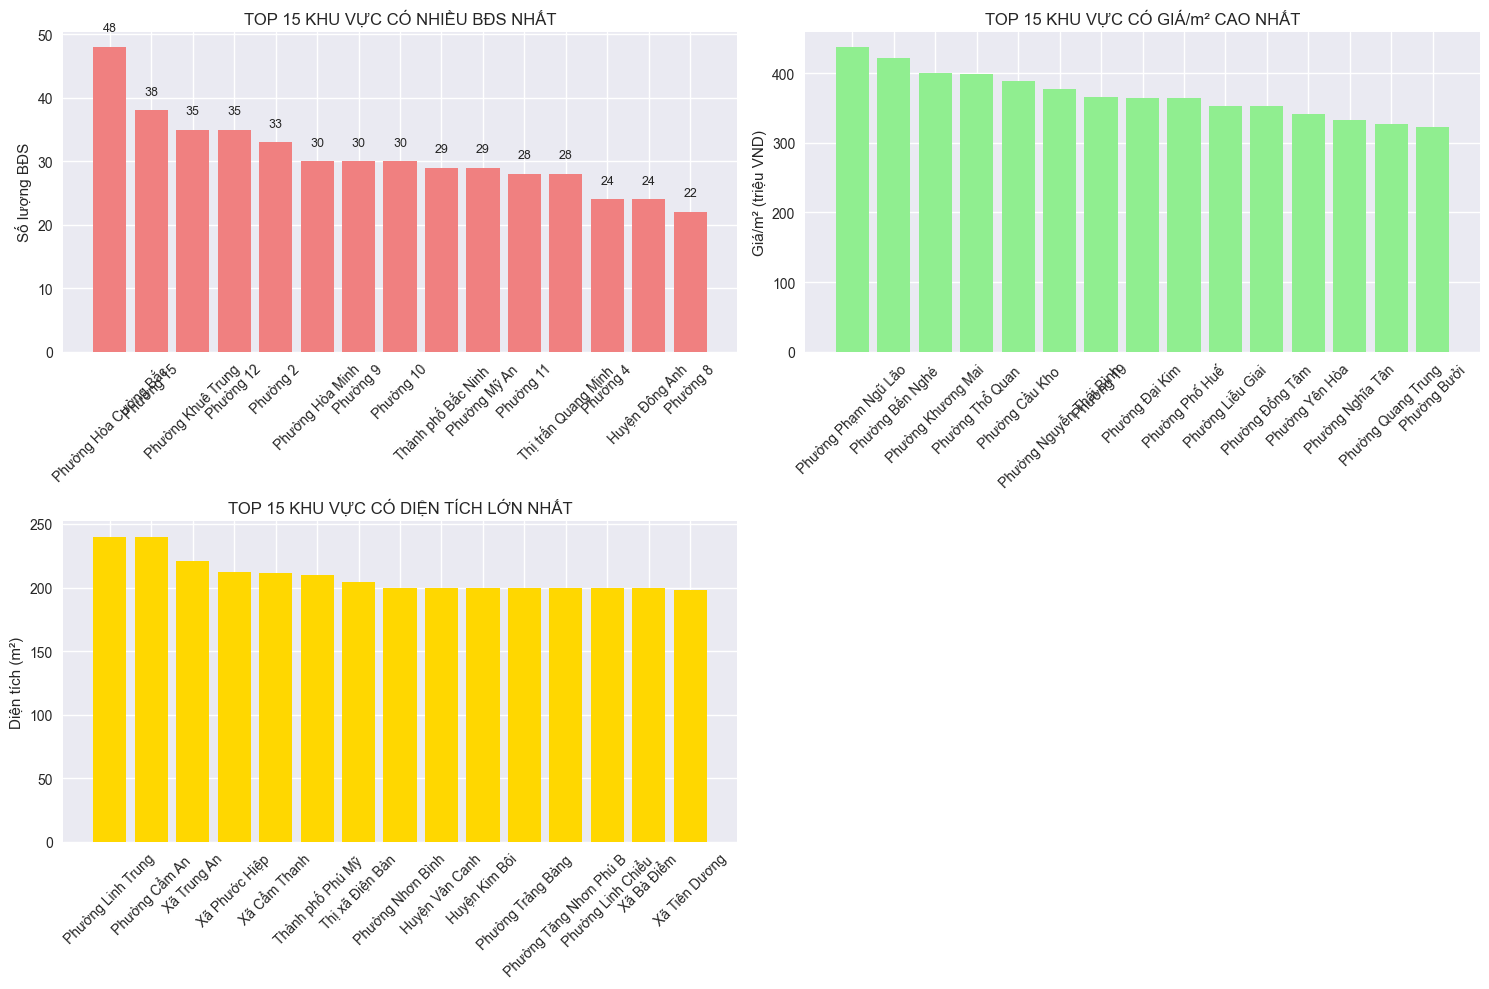

In [17]:
##  PHÂN TÍCH THEO VỊ TRÍ ĐỊA LÝ

# %%
if len(df) > 0 and 'District' in df.columns:
    # 3.1 Phân tích theo KHU VỰC
    plt.figure(figsize=(15, 10))
    
    # Top quận có nhiều BĐS nhất
    district_counts = df['District'].value_counts().head(15)
    
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(range(len(district_counts)), district_counts.values, color='lightcoral')
    plt.title('TOP 15 KHU VỰC CÓ NHIỀU BĐS NHẤT')
    plt.xticks(range(len(district_counts)), district_counts.index, rotation=45)
    plt.ylabel('Số lượng BĐS')
    
    # Thêm số liệu trên cột
    for bar, count in zip(bars1, district_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{count}', 
                ha='center', va='bottom', fontsize=9)
    
    # Giá trung bình theo quận
    plt.subplot(2, 2, 2)
    district_price = df.groupby('District')['Price_per_m2'].mean().sort_values(ascending=False).head(15)
    bars2 = plt.bar(range(len(district_price)), district_price.values / 1e6, color='lightgreen')
    plt.title('TOP 15 KHU VỰC CÓ GIÁ/m² CAO NHẤT')
    plt.xticks(range(len(district_price)), district_price.index, rotation=45)
    plt.ylabel('Giá/m² (triệu VND)')
    
    # Diện tích trung bình theo quận
    plt.subplot(2, 2, 3)
    district_area = df.groupby('District')['Area_clean'].mean().sort_values(ascending=False).head(15)
    bars3 = plt.bar(range(len(district_area)), district_area.values, color='gold')
    plt.title('TOP 15 KHU VỰC CÓ DIỆN TÍCH LỚN NHẤT')
    plt.xticks(range(len(district_area)), district_area.index, rotation=45)
    plt.ylabel('Diện tích (m²)')
    
    
    plt.tight_layout()
    plt.show()

 Tổng số dòng dữ liệu ban đầu: 2422

 CHUẨN HÓA LẠI CỘT BEDROOM...
Kiểu dữ liệu Bedroom: object
Mẫu giá trị Bedroom:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: Bedroom, dtype: object
Số lượng giá trị hợp lệ trong Bedroom_numeric: 1700
Phân phối Bedroom_numeric:
Bedroom_numeric
1.0      74
2.0     242
3.0     471
4.0     421
5.0     162
6.0      93
7.0      36
8.0      38
9.0      19
10.0     25
Name: count, dtype: int64
 Đã thêm Bedroom_numeric vào phân tích
 Các cột số sẽ phân tích: ['Price_clean', 'Area_clean', 'Price_per_m2', 'Bedroom_numeric']
 Kích thước dữ liệu số: (2422, 4)
 Kích thước sau khi làm sạch NaN: (1700, 4)
 MA TRẬN TƯƠNG QUAN:
                 Price_clean  Area_clean  Price_per_m2  Bedroom_numeric
Price_clean            1.000       0.257         0.691            0.375
Area_clean             0.257       1.000        -0.388            0.177
Price_per_m2           0.691      -0.388         1.000            0.201
Bedroo

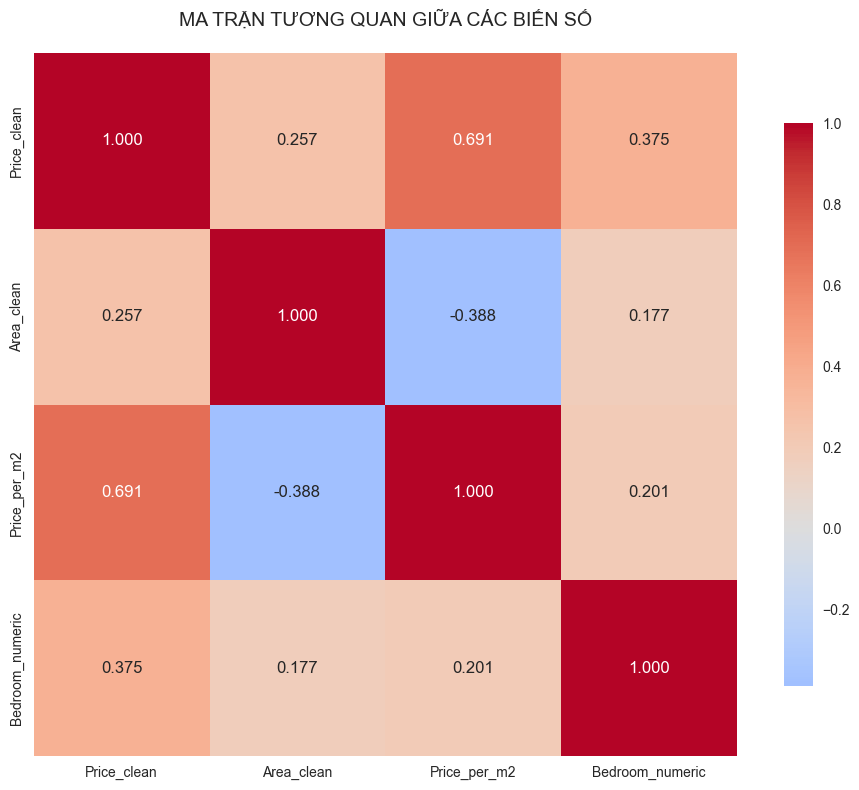


 PHÂN TÍCH CHI TIẾT MỐI QUAN HỆ:
• Correlation (Diện tích vs Giá): 0.257
• Correlation (Diện tích vs Giá/m²): -0.388
• Correlation (Phòng ngủ vs Giá): 0.375


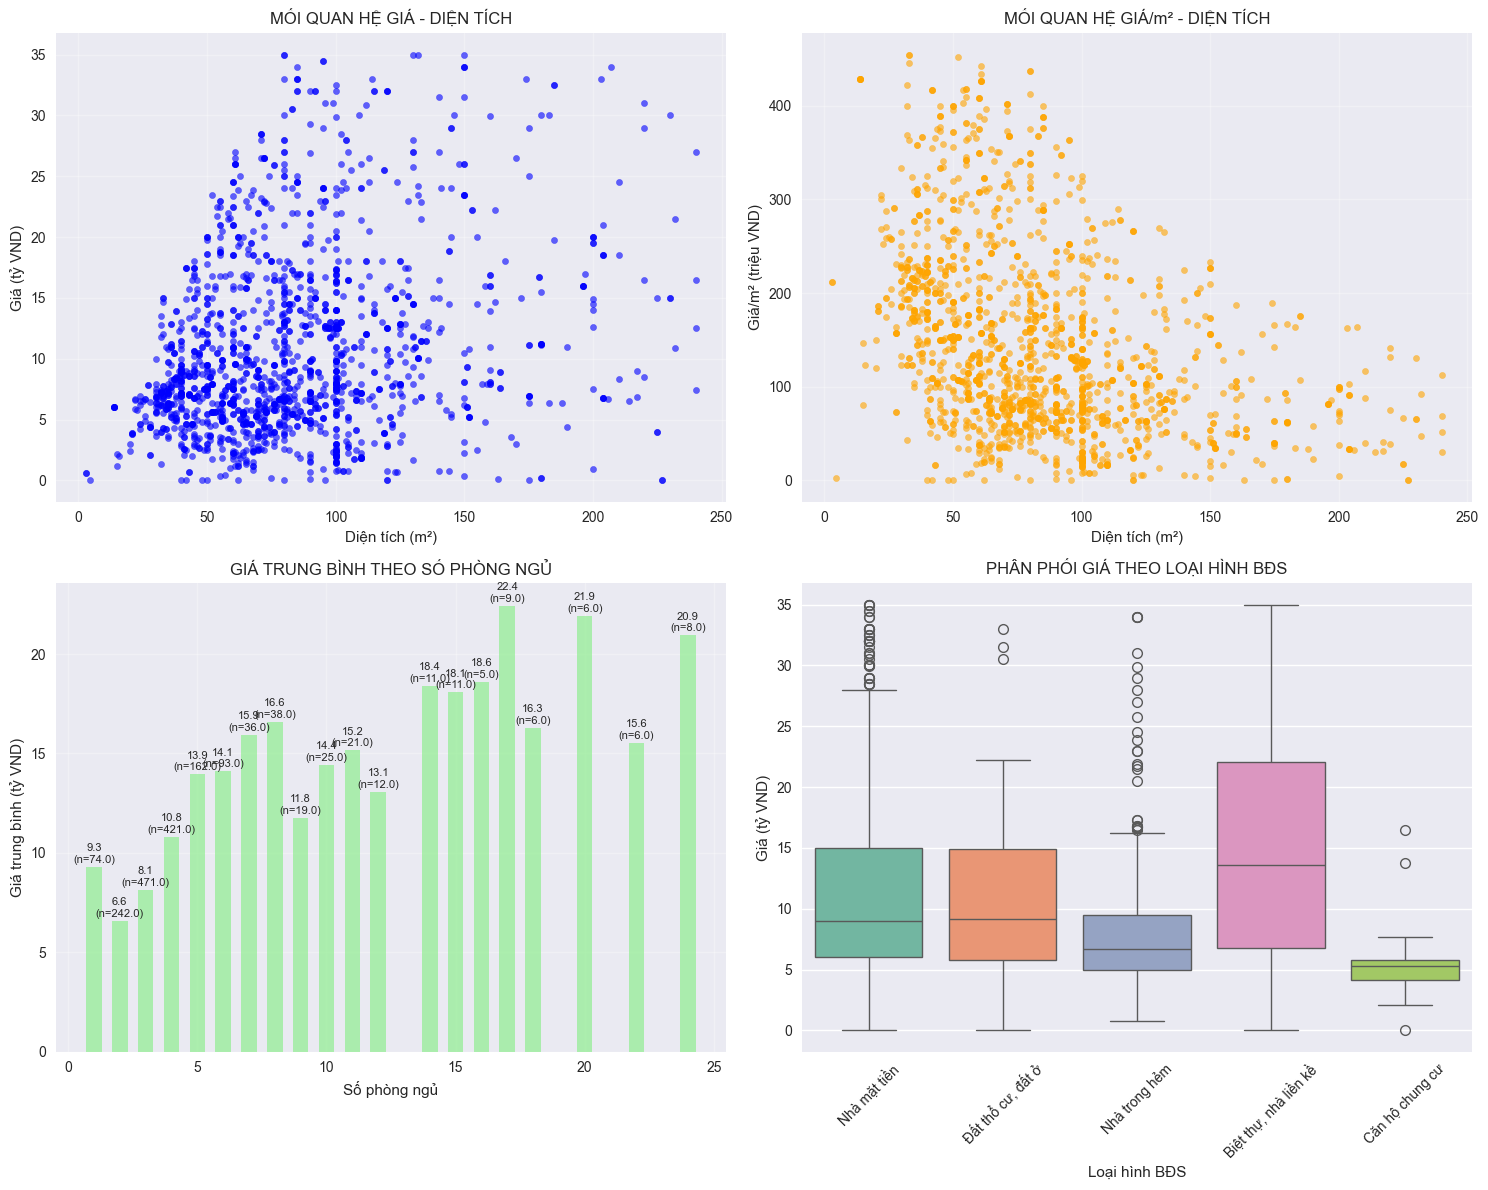


===  PHÂN TÍCH SỐ TẦNG/LẦU ===
 Giá trị unique trong cột 'floors':
floors
3 lầu     351
2 lầu     289
5 lầu     274
4 lầu     271
1 lầu     262
6 lầu      95
7 lầu      50
8 lầu      20
20 lầu      9
15 lầu      8
Name: count, dtype: int64
 Số lượng bản ghi có số tầng hợp lệ: 1672


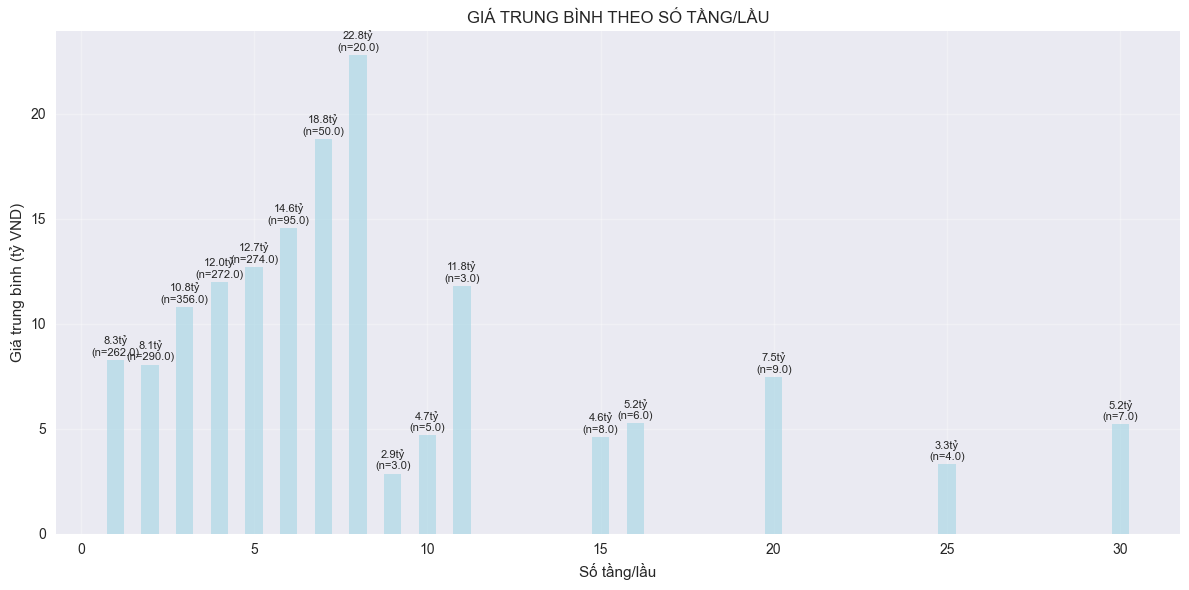


 HOÀN TẤT PHÂN TÍCH MỐI QUAN HỆ!


In [18]:
##  PHÂN TÍCH MỐI QUAN HỆ GIỮA CÁC BIẾN

# %%
if len(df) > 0:
    print(f" Tổng số dòng dữ liệu ban đầu: {len(df)}")
    
    # 3.8.0 CHUẨN HÓA LẠI CỘT BEDROOM TRƯỚC KHI PHÂN TÍCH
    print("\n CHUẨN HÓA LẠI CỘT BEDROOM...")
    
    # Tạo bản copy để tránh thay đổi dataframe gốc
    df_analysis = df.copy()
    
    # Chuẩn hóa cột Bedroom - xử lý cả số và text
    if 'Bedroom' in df_analysis.columns:
        # Kiểm tra kiểu dữ liệu hiện tại
        print(f"Kiểu dữ liệu Bedroom: {df_analysis['Bedroom'].dtype}")
        print("Mẫu giá trị Bedroom:")
        print(df_analysis['Bedroom'].head(10))
        
        # Chuẩn hóa: chuyển sang string, trích xuất số, chuyển sang float
        df_analysis['Bedroom_numeric'] = (
            df_analysis['Bedroom']
            .astype(str)
            .str.extract(r'(\d+\.?\d*)')  # Lấy số (có thể có thập phân)
            .astype(float)                # Chuyển sang float
        )
        
        print(f"Số lượng giá trị hợp lệ trong Bedroom_numeric: {df_analysis['Bedroom_numeric'].notna().sum()}")
        print("Phân phối Bedroom_numeric:")
        print(df_analysis['Bedroom_numeric'].value_counts().sort_index().head(10))
    
    # 3.8.1 Ma trận tương quan - chỉ lấy các cột thực sự là số
    numeric_cols = ['Price_clean', 'Area_clean', 'Price_per_m2']
    
    # Thêm Bedroom_numeric nếu đã chuẩn hóa thành công
    if 'Bedroom_numeric' in df_analysis.columns and df_analysis['Bedroom_numeric'].notna().sum() > 0:
        numeric_cols.append('Bedroom_numeric')
        print(" Đã thêm Bedroom_numeric vào phân tích")
    
    # Chỉ lấy các cột tồn tại và có dữ liệu số
    numeric_cols = [col for col in numeric_cols if col in df_analysis.columns]
    print(f" Các cột số sẽ phân tích: {numeric_cols}")
    
    if len(numeric_cols) > 1:
        # Lấy dữ liệu số
        corr_data = df_analysis[numeric_cols].copy()
        print(f" Kích thước dữ liệu số: {corr_data.shape}")
        
        # Loại bỏ các hàng có giá trị NaN trong các cột số
        corr_data_clean = corr_data.dropna()
        print(f" Kích thước sau khi làm sạch NaN: {corr_data_clean.shape}")
        
        if len(corr_data_clean) > 1:
            # 4.1.1 MA TRẬN TƯƠNG QUAN
            plt.figure(figsize=(10, 8))
            correlation_matrix = corr_data_clean.corr()
            
            print(" MA TRẬN TƯƠNG QUAN:")
            print(correlation_matrix.round(3))

            # Heatmap tương quan
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                        square=True, fmt='.3f', cbar_kws={'shrink': 0.8},
                        annot_kws={'size': 12})
            plt.title('MA TRẬN TƯƠNG QUAN GIỮA CÁC BIẾN SỐ', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()

            # 4.2 PHÂN TÍCH CHI TIẾT TỪNG MỐI QUAN HỆ
            print("\n PHÂN TÍCH CHI TIẾT MỐI QUAN HỆ:")
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            plots_created = 0

            # SUBPLOT 1: Giá vs Diện tích
            if 'Area_clean' in corr_data_clean.columns and 'Price_clean' in corr_data_clean.columns:
                axes[0,0].scatter(corr_data_clean['Area_clean'], corr_data_clean['Price_clean']/1e9, 
                                alpha=0.6, s=20, color='blue')
                axes[0,0].set_xlabel('Diện tích (m²)')
                axes[0,0].set_ylabel('Giá (tỷ VND)')
                axes[0,0].set_title('MỐI QUAN HỆ GIÁ - DIỆN TÍCH')
                axes[0,0].grid(True, alpha=0.3)
                plots_created += 1
                
                # Tính correlation
                corr_value = corr_data_clean['Area_clean'].corr(corr_data_clean['Price_clean'])
                print(f"• Correlation (Diện tích vs Giá): {corr_value:.3f}")

            # SUBPLOT 2: Giá/m² vs Diện tích
            if 'Area_clean' in corr_data_clean.columns and 'Price_per_m2' in corr_data_clean.columns:
                axes[0,1].scatter(corr_data_clean['Area_clean'], corr_data_clean['Price_per_m2']/1e6, 
                                alpha=0.6, s=20, color='orange')
                axes[0,1].set_xlabel('Diện tích (m²)')
                axes[0,1].set_ylabel('Giá/m² (triệu VND)')
                axes[0,1].set_title('MỐI QUAN HỆ GIÁ/m² - DIỆN TÍCH')
                axes[0,1].grid(True, alpha=0.3)
                plots_created += 1
                
                corr_value = corr_data_clean['Area_clean'].corr(corr_data_clean['Price_per_m2'])
                print(f"• Correlation (Diện tích vs Giá/m²): {corr_value:.3f}")

            # SUBPLOT 3: Giá vs Số phòng ngủ
            if 'Bedroom_numeric' in corr_data_clean.columns and 'Price_clean' in corr_data_clean.columns:
                bedroom_price = corr_data_clean.groupby('Bedroom_numeric')['Price_clean'].agg(['mean', 'count']).reset_index()
                bedroom_price = bedroom_price[bedroom_price['count'] >= 5]  # Chỉ lấy nhóm có ít nhất 5 mẫu
                
                if len(bedroom_price) > 0:
                    axes[1,0].bar(bedroom_price['Bedroom_numeric'], bedroom_price['mean']/1e9, 
                                color='lightgreen', alpha=0.7, width=0.6)
                    axes[1,0].set_xlabel('Số phòng ngủ')
                    axes[1,0].set_ylabel('Giá trung bình (tỷ VND)')
                    axes[1,0].set_title('GIÁ TRUNG BÌNH THEO SỐ PHÒNG NGỦ')
                    axes[1,0].grid(True, alpha=0.3)
                    plots_created += 1
                    
                    # Thêm số liệu trên cột
                    for i, row in bedroom_price.iterrows():
                        axes[1,0].text(row['Bedroom_numeric'], row['mean']/1e9 + 0.1, 
                                     f'{row["mean"]/1e9:.1f}\n(n={row["count"]})', 
                                     ha='center', va='bottom', fontsize=8)
                    
                    corr_value = corr_data_clean['Bedroom_numeric'].corr(corr_data_clean['Price_clean'])
                    print(f"• Correlation (Phòng ngủ vs Giá): {corr_value:.3f}")

            # SUBPLOT 4: Phân phối giá theo loại hình BĐS
            if 'Property Type' in df_analysis.columns:
                # Lấy chỉ mục từ dữ liệu đã làm sạch
                clean_indices = corr_data_clean.index
                plot_data = df_analysis.loc[clean_indices].copy()
                plot_data['Price_billion'] = plot_data['Price_clean'] / 1e9
                
                # Lấy top 5 loại hình phổ biến nhất
                top_properties = plot_data['Property Type'].value_counts().head(5).index
                prop_data = plot_data[plot_data['Property Type'].isin(top_properties)]
                
                if len(prop_data) > 0 and len(top_properties) > 1:
                    sns.boxplot(data=prop_data, x='Property Type', y='Price_billion', ax=axes[1,1],
                               palette='Set2')
                    axes[1,1].set_xlabel('Loại hình BĐS')
                    axes[1,1].set_ylabel('Giá (tỷ VND)')
                    axes[1,1].set_title('PHÂN PHỐI GIÁ THEO LOẠI HÌNH BĐS')
                    axes[1,1].tick_params(axis='x', rotation=45)
                    plots_created += 1
                else:
                    # Thay thế bằng histogram giá nếu không có đủ loại hình
                    axes[1,1].hist(plot_data['Price_billion'], bins=30, alpha=0.7, color='purple')
                    axes[1,1].set_xlabel('Giá (tỷ VND)')
                    axes[1,1].set_ylabel('Số lượng')
                    axes[1,1].set_title('PHÂN PHỐI GIÁ BẤT ĐỘNG SẢN')
                    axes[1,1].grid(True, alpha=0.3)
                    plots_created += 1

            # Ẩn subplot không sử dụng
            for i in range(2):
                for j in range(2):
                    if not axes[i,j].has_data():
                        axes[i,j].set_visible(False)
            
            if plots_created > 0:
                plt.tight_layout()
                plt.show()
            else:
                print(" Không có đủ dữ liệu để vẽ biểu đồ")
                plt.close(fig)
            
        else:
            print(" Không đủ dữ liệu số sau khi làm sạch")
    else:
        print(" Không đủ cột số để phân tích tương quan")
        
    # 3.8.3 PHÂN TÍCH RIÊNG CHO CỘT FLOORS (xử lý text)
    if 'floors' in df_analysis.columns:
        print("\n===  PHÂN TÍCH SỐ TẦNG/LẦU ===")
        print(" Giá trị unique trong cột 'floors':")
        print(df_analysis['floors'].value_counts().head(10))
        
        # Trích xuất số từ cột floors với xử lý lỗi
        try:
            df_analysis['floors_numeric'] = (
                df_analysis['floors']
                .astype(str)
                .str.extract(r'(\d+\.?\d*)')  # Lấy số (có thể có thập phân)
                .astype(float)                # Chuyển sang float
            )
            
            floors_clean = df_analysis[df_analysis['floors_numeric'].notna()]
            
            if len(floors_clean) > 0:
                print(f" Số lượng bản ghi có số tầng hợp lệ: {len(floors_clean)}")
                
                fig, ax = plt.subplots(figsize=(12, 6))
                floors_price = floors_clean.groupby('floors_numeric')['Price_clean'].agg(['mean', 'count']).reset_index()
                floors_price = floors_price[floors_price['count'] >= 3]  # Chỉ lấy nhóm có ít nhất 3 mẫu
                
                if len(floors_price) > 0:
                    ax.bar(floors_price['floors_numeric'], floors_price['mean']/1e9, 
                          color='lightblue', alpha=0.7, width=0.5)
                    ax.set_xlabel('Số tầng/lầu')
                    ax.set_ylabel('Giá trung bình (tỷ VND)')
                    ax.set_title('GIÁ TRUNG BÌNH THEO SỐ TẦNG/LẦU')
                    ax.grid(True, alpha=0.3)
                    
                    # Thêm số liệu trên cột
                    for i, row in floors_price.iterrows():
                        ax.text(row['floors_numeric'], row['mean']/1e9 + 0.1, 
                              f'{row["mean"]/1e9:.1f}tỷ\n(n={row["count"]})', 
                              ha='center', va='bottom', fontsize=8)
                    
                    plt.tight_layout()
                    plt.show()
                else:
                    print(" Không đủ dữ liệu số tầng để phân tích")
            else:
                print(" Không có giá trị số tầng hợp lệ")
                
        except Exception as e:
            print(f" Lỗi khi xử lý cột floors: {e}")
    
else:
    print(" DataFrame trống")

print("\n HOÀN TẤT PHÂN TÍCH MỐI QUAN HỆ!")

In [19]:
## PHÂN TÍCH THEO THỜI GIAN (NẾU CÓ)

# %%
if len(df) > 0:
    # 5.1 Kiểm tra nếu có cột ngày tháng
    date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

    if date_columns:
        print(f" Phát hiện cột thời gian: {date_columns}")
    else:
        print(" Không tìm thấy cột thời gian trong dataset")

 Không tìm thấy cột thời gian trong dataset


 PHÂN TÍCH TỪ KHÓA TRONG TIÊU ĐỀ
chính_chủ      :   90 BĐS (3.7%)
giá_rẻ         :   34 BĐS (1.4%)
view_đẹp       :    4 BĐS (0.2%)
mặt_tiền       :  388 BĐS (16.0%)
sổ_đỏ          :   16 BĐS (0.7%)
sổ_hồng        :   43 BĐS (1.8%)


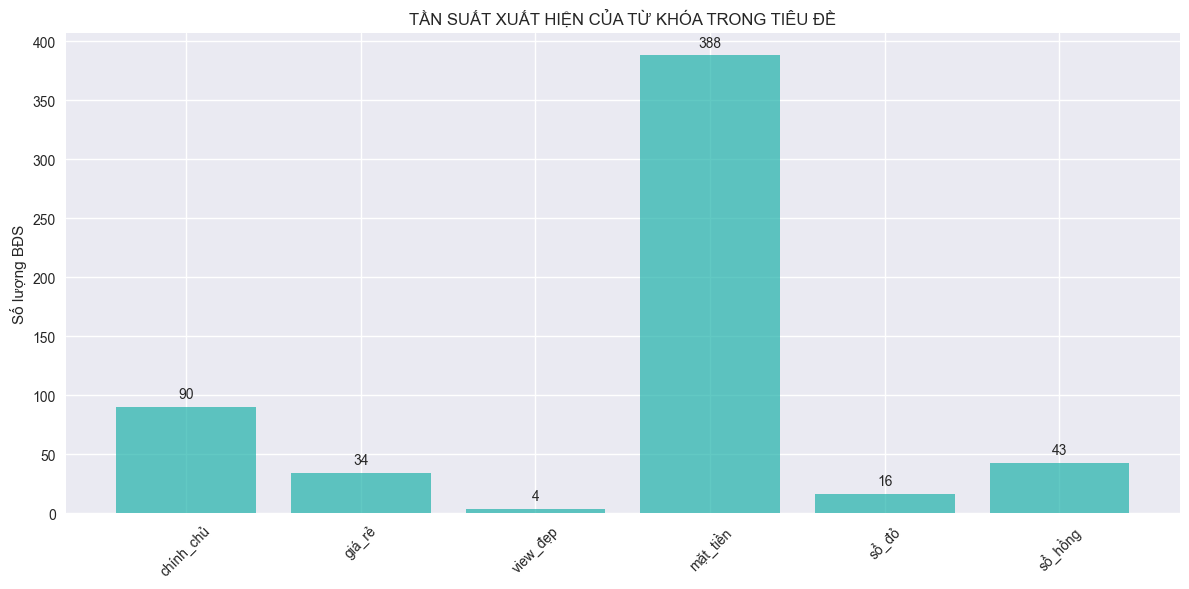

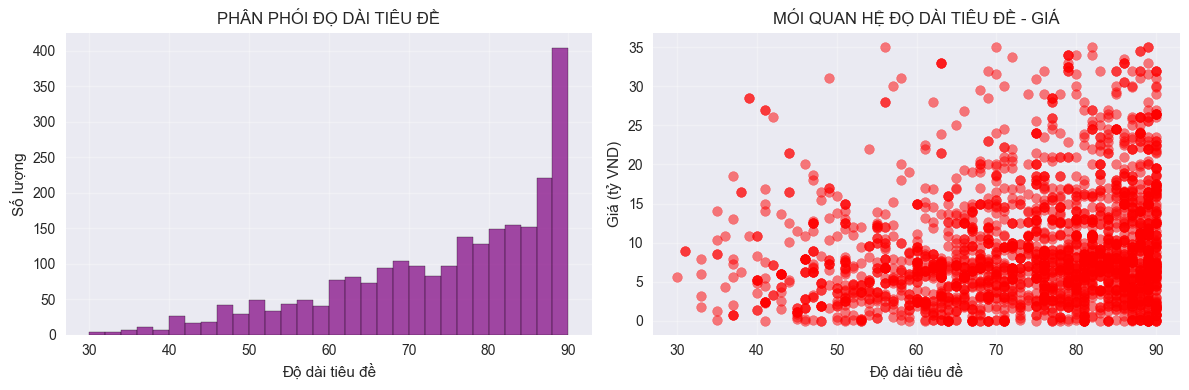

In [20]:
##  PHÂN TÍCH CÁC BIẾN PHỤ TRỢ

# %%
if len(df) > 0:
    # 3.9.1 Phân tích từ khóa trong tiêu đề
    keyword_cols = [col for col in df.columns if 'Keyword' in col]

    if keyword_cols:
        print(" PHÂN TÍCH TỪ KHÓA TRONG TIÊU ĐỀ")
        
        plt.figure(figsize=(12, 6))
        keyword_stats = {}
        
        for keyword_col in keyword_cols:
            count = df[keyword_col].sum()
            percentage = (count / len(df)) * 100
            keyword_name = keyword_col.replace('Keyword_', '')
            keyword_stats[keyword_name] = count
            print(f"{keyword_name:<15}: {count:>4} BĐS ({percentage:.1f}%)")
        
        # Biểu đồ từ khóa
        plt.bar(keyword_stats.keys(), keyword_stats.values(), color='lightseagreen', alpha=0.7)
        plt.title('TẦN SUẤT XUẤT HIỆN CỦA TỪ KHÓA TRONG TIÊU ĐỀ')
        plt.xticks(rotation=45)
        plt.ylabel('Số lượng BĐS')
        
        # Thêm số liệu trên cột
        for i, v in enumerate(keyword_stats.values()):
            plt.text(i, v + 5, f'{v}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

    # 3.9.2 Phân tích độ dài tiêu đề
    if 'Title_Length' in df.columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(df['Title_Length'], bins=30, alpha=0.7, edgecolor='black', color='purple')
        plt.xlabel('Độ dài tiêu đề')
        plt.ylabel('Số lượng')
        plt.title('PHÂN PHỐI ĐỘ DÀI TIÊU ĐỀ')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(df['Title_Length'], df['Price_clean']/1e9, alpha=0.5, color='red')
        plt.xlabel('Độ dài tiêu đề')
        plt.ylabel('Giá (tỷ VND)')
        plt.title('MỐI QUAN HỆ ĐỘ DÀI TIÊU ĐỀ - GIÁ')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

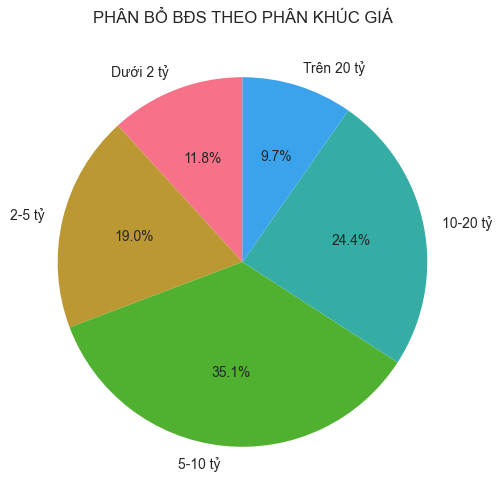

 PHÂN KHÚC GIÁ THỊ TRƯỜNG:
Dưới 2 tỷ   :  285 BĐS (11.8%)
2-5 tỷ      :  460 BĐS (19.0%)
5-10 tỷ     :  850 BĐS (35.1%)
10-20 tỷ    :  592 BĐS (24.4%)
Trên 20 tỷ  :  235 BĐS (9.7%)

 PHÂN KHÚC DIỆN TÍCH:
Dưới 50m²   :  389 BĐS (16.1%)
50-80m²     :  698 BĐS (28.8%)
80-120m²    :  844 BĐS (34.8%)
120-200m²   :  388 BĐS (16.0%)
Trên 200m²  :  103 BĐS (4.3%)


In [21]:
##  PHÂN TÍCH NGOẠI LỆ VÀ CỤM GIÁ TRỊ

# %%
if len(df) > 0:
    # 3.10.1 Phân tích các segment giá
    def create_price_segments(price_series):
        segments = {
            'Dưới 2 tỷ': (0, 2e9),
            '2-5 tỷ': (2e9, 5e9),
            '5-10 tỷ': (5e9, 10e9),
            '10-20 tỷ': (10e9, 20e9),
            'Trên 20 tỷ': (20e9, float('inf'))
        }
        
        segment_counts = {}
        for segment, (low, high) in segments.items():
            count = ((price_series >= low) & (price_series < high)).sum()
            segment_counts[segment] = count
        
        return segment_counts

    price_segments = create_price_segments(df['Price_clean'])

    plt.figure(figsize=(10, 6))
    plt.pie(price_segments.values(), labels=price_segments.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('PHÂN BỔ BĐS THEO PHÂN KHÚC GIÁ')
    plt.show()

    print(" PHÂN KHÚC GIÁ THỊ TRƯỜNG:")
    for segment, count in price_segments.items():
        percentage = (count / len(df)) * 100
        print(f"{segment:<12}: {count:>4} BĐS ({percentage:.1f}%)")

    # 3.10.2 Phân tích các segment diện tích
    def create_area_segments(area_series):
        segments = {
            'Dưới 50m²': (0, 50),
            '50-80m²': (50, 80),
            '80-120m²': (80, 120),
            '120-200m²': (120, 200),
            'Trên 200m²': (200, float('inf'))
        }
        
        segment_counts = {}
        for segment, (low, high) in segments.items():
            count = ((area_series >= low) & (area_series < high)).sum()
            segment_counts[segment] = count
        
        return segment_counts

    area_segments = create_area_segments(df['Area_clean'])

    print("\n PHÂN KHÚC DIỆN TÍCH:")
    for segment, count in area_segments.items():
        percentage = (count / len(df)) * 100
        print(f"{segment:<12}: {count:>4} BĐS ({percentage:.1f}%)")

In [22]:
##  KẾT LUẬN EDA TỔNG QUAN

# %%
if len(df) > 0:
    print(" KẾT LUẬN EDA TỔNG QUAN")
    print("=" * 50)

    # Thống kê tổng quan
    print(f"• Tổng số BĐS phân tích: {len(df):,}")
    print(f"• Giá trung bình: {df['Price_clean'].mean()/1e9:.1f} tỷ VND")
    print(f"• Diện tích trung bình: {df['Area_clean'].mean():.0f} m²")
    print(f"• Giá/m² trung bình: {df['Price_per_m2'].mean()/1e6:.1f} triệu VND/m²")

    # Phân tích độ biến động
    price_cv = (df['Price_clean'].std() / df['Price_clean'].mean()) * 100
    area_cv = (df['Area_clean'].std() / df['Area_clean'].mean()) * 100

    print(f"• Độ biến động giá: {price_cv:.1f}%")
    print(f"• Độ biến động diện tích: {area_cv:.1f}%")

    # Phân tích tương quan
    if 'Area_clean' in df.columns and 'Price_clean' in df.columns:
        correlation = df['Area_clean'].corr(df['Price_clean'])
        print(f"• Tương quan Diện tích-Giá: {correlation:.3f}")

    # Lưu kết quả EDA
    eda_summary = {
        'total_properties': len(df),
        'avg_price': df['Price_clean'].mean(),
        'avg_area': df['Area_clean'].mean(),
        'avg_price_per_m2': df['Price_per_m2'].mean(),
        'price_std': df['Price_clean'].std(),
        'area_std': df['Area_clean'].std()
    }

    print(" HOÀN TẤT PHÂN TÍCH EDA!")
else:
    print(" KHÔNG THỂ THỰC HIỆN EDA DO THIẾU DỮ LIỆU")

 KẾT LUẬN EDA TỔNG QUAN
• Tổng số BĐS phân tích: 2,422
• Giá trung bình: 9.2 tỷ VND
• Diện tích trung bình: 89 m²
• Giá/m² trung bình: 122.3 triệu VND/m²
• Độ biến động giá: 78.8%
• Độ biến động diện tích: 49.7%
• Tương quan Diện tích-Giá: 0.160
 HOÀN TẤT PHÂN TÍCH EDA!
